# Tarea 2 Métodos para Clasificación
---
## Integrantes: 
- *José Eduardo Caimapo* -  jose.caimapo.12@sansano.usm.cl - 201373573-8
- *Rodrigo Sepúlveda* - rodrigo.sepulveda.12@sansano.usm.cl - 201204766-8

# 1. Tipos de fronteras en Clasificación

En la siguiente sección se estudiarán las fronteras generadas por los siguientes tipos de algoritmos de clasificación: Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Regresíon Logística (RL), Máquina de Vectores de Soporte (SVM), arboles de clasificación, y el algoritmo *k-NN*. Para realizar la tarea anterior de generó un conjunto de datos sintético de dos dimensiones, el cual se conforma dos clases de datos. La primera clase de datos pose una forma ovalada, y se genera a través de una distribución multivariada gaussiana, además a esta clase se le agrega ruido para dificultar la tarea en la generación de la frontera. La segunda clase de datos pose una forma de semi-luna, generada mediante las funciones seno y coseno. 

In [264]:
# Imports 
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from ipywidgets                    import interactive
from scipy                         import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model          import LogisticRegression            as LR
from sklearn.metrics               import accuracy_score
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import SVC                           as SVM
from sklearn.tree                  import DecisionTreeClassifier        as Tree
from sklearn.utils                 import check_random_state

El siguiente código corresponde a la función encargada de generar el conjunto de datos a utilizar en esta sección.

In [196]:
def get_dataset(n_samples=500, mean=(0,-4), n=20):    
    C = np.array([[0.3, 0.1], [0.1, 1.5]])
    datos1 = np.random.multivariate_normal(mean, C, n_samples)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
    datos2 = np.vstack((outer_circ_x,outer_circ_y)).T
    generator = check_random_state(10)
    datos2 += generator.normal(scale=0.3, size=datos2.shape)
    X = np.concatenate((datos1, datos2), axis=0)
    y1 = np.zeros(datos1.shape[0]+n)
    y2 = np.ones(datos2.shape[0]-n)
    y = np.concatenate((y1,y2),axis=0)
    return (X,y)

El siguiente código corresponde a la función encargada de graficar el conjunto de datos y la frontera generada:

In [197]:
def visualize_border(model, x_data, y_data, title='', legend=['Categoria1', 'Categoria 2']):
    fig = plt.figure(figsize=(12,6))
    classes = [0,1]
    colors = [plt.cm.cool(float(i)) for i in classes]
    plt.scatter(x_data[y_data==0][:,0], x_data[y_data==0][:,1], s=50, c=colors[0], label=legend[0])
    plt.scatter(x_data[y_data==1][:,0], x_data[y_data==1][:,1], s=50, c=colors[1], label=legend[1])
    plt.grid(True)
    if model != None:
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z[:,0].reshape(xx.shape)
        plt.contour(xx, yy, Z, 1, cmap=plt.cm.hot)
        plt.axis((x_min, x_max, y_min, y_max))
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

El siguiente código corresponde a la función encargada de visualizar un heatmap de la probabilidad de los puntos del plano de pertenecer a una clase o a otra. 

In [382]:
def visualize_heatmap(model, x_data, y_data, title=''):
    fig = plt.figure(figsize=(13,5))
    plt.grid(True)
    plt.scatter(x_data[:,0], x_data[:,1], s=30, c=y_train, cmap=plt.cm.autumn)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    hb = plt.hexbin(xx.ravel(), yy.ravel(), C=Z.ravel(),  cmap=plt.cm.plasma)
    plt.scatter(x_data[:,0], x_data[:,1], s=30, c=y_train, cmap=plt.cm.cool)
    plt.axis((x_min, x_max, y_min, y_max))
    cb = fig.colorbar(hb, aspect=12)
    cb.set_label('Probabilidad')
    plt.title(title)
    plt.show()

El siguiente código corresponde a la función encargada de graficar la frontera determinada por el modelo elegido, y con el parametro elegido mediante interactive. 

In [383]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model, x_train, y_train)
    visualize_heatmap(model, x_train, y_train)

## a) Construya el conjunto de datos sintético, determine la cantidad de elementos por clase y visualícelo.


Se procede a construir el conjunto de datos a utilizar durante la pregunta:

In [200]:
x_train, y_train = get_dataset()

In [201]:
index_names = ['Categoria 1', 'Categoria 2']
Ax1 = x_train[y_train==0][:, 0]; Ay1 = x_train[y_train==0][:, 1]
Ax2 = x_train[y_train==1][:, 0]; Ay2 = x_train[y_train==1][:, 1]

data = {
    'count':  pd.Series([len(Ax1), len(Ax2)], index = index_names),
    'min X':  pd.Series([Ax1.min(),  Ax2.min()], index = index_names),
    'max X':  pd.Series([Ax1.max(),  Ax2.max()], index = index_names),
    'mean X': pd.Series([Ax1.mean(), Ax2.mean()], index = index_names),
    'std X':  pd.Series([Ax1.std(),  Ax2.std()], index = index_names),
    'min Y':  pd.Series([Ay1.min(),  Ay2.min()], index = index_names),
    'max Y':  pd.Series([Ay1.max(),  Ay2.max()], index = index_names),
    'mean Y': pd.Series([Ay1.mean(), Ay2.mean()], index = index_names),
    'std Y':  pd.Series([Ay1.std(),  Ay2.std()], index = index_names),
}

del Ax1; del Ax2

pd.DataFrame(data)[['count', 'mean X', 'std X', 'mean Y', 'std Y', 'min X', 'max X', 'min Y', 'max Y']]

,count,mean X,std X,mean Y,std Y,min X,max X,min Y,max Y
Categoria 1,520,0.081347,0.795283,-3.816514,1.479160,-1.758881,3.440547,-7.669183,0.923085
Categoria 2,480,-0.126455,2.125896,1.966354,0.920259,-3.724319,3.671919,-0.492837,3.652657


El conjunto de datos sintético, se compone de 1000 registros de los cuales 520 pertenecen a la categoría 1, y 480 pertenecen a la categoría 2. De la información mostrada del conjunto de datos se aprecia que el rango de valores para el eje X en ambos conjuntos es similar en valores y amplitud, lo cual se aprecia en la cercanía de los promedios de la componente X. En cambio, el rango de valores para el eje Y es considerablemente distinto, ya que la categoría 1 pose una amplitud mayor a 7 y la categoría 2 pose una amplitud mayor a 3, los promedios en este eje están a una distancian en al menos 5 unidades. De lo anterior se puede suponer que la componente Y será de mayor importancia en la clasificación de las distintas clases.

Se procede a graficar el conjunto de datos generado.

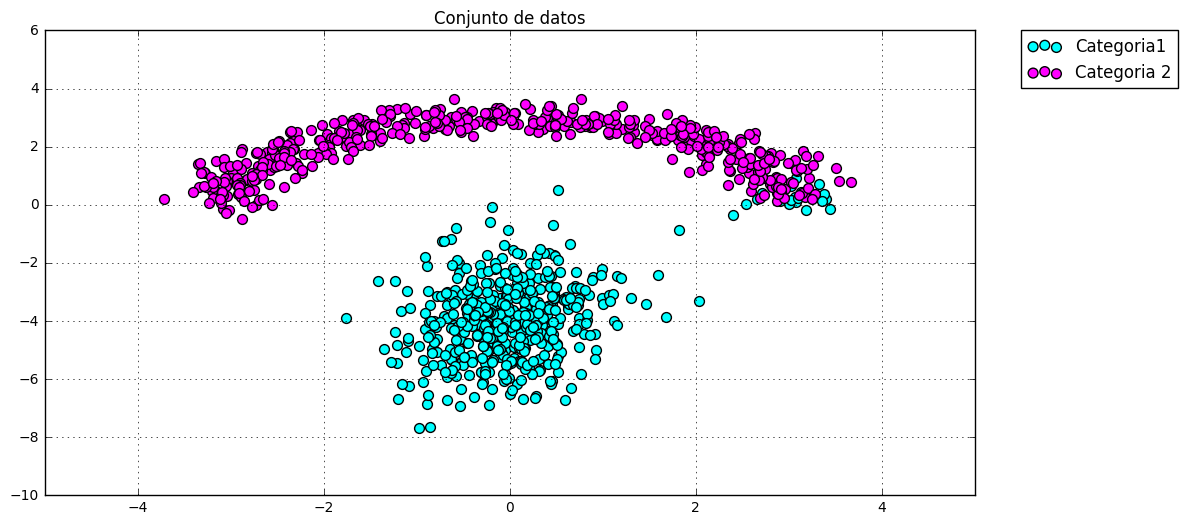

In [202]:
visualize_border(None, x_train, y_train, 'Conjunto de datos')

De la visualización del conjunto de datos es posible apreciar que este no corresponde a un conjunto linealmente separable ya que existe una superposición de las dos categorías, lo cual puede afectar el rendimiento de algunos clasificadores que asumen la separabilidad de las categorías. De igual manera se aprecia que la mayor diferencia entre las categorías se encuentra en la componente Y, reforzando lo ya mencionado de que la componente Y será la más significante en la tarea de clasificación.

## b) Entrene  el  clasificador Linear  Discriminant  Analysis (LDA)  y  visualice  la  frontera  de  decisión  que define este algoritmo. Analice cualitativamente lo que observa.

In [203]:
lda_model = LDA(store_covariance=True)
lda_model.fit(x_train,y_train);

Se entrena un clasificador LDA con el conjunto de datos creado, para visualizar el comportamiento del clasificador se grafica el conjunto de datos junto a la frontera determinada por LDA.

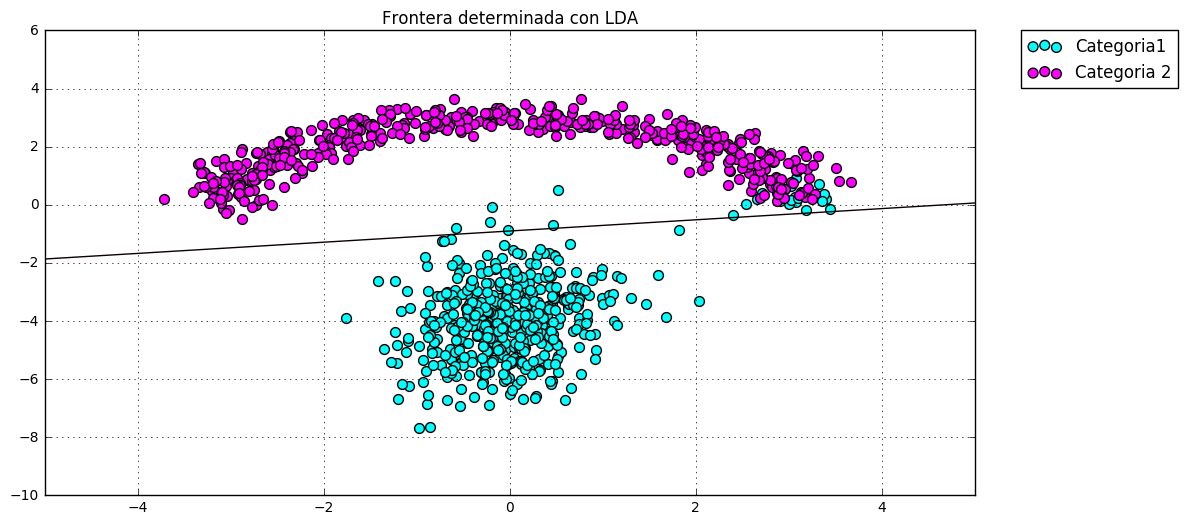

In [237]:
visualize_border(lda_model, x_train, y_train, 'Frontera determinada con LDA')

De la frontera determinada por LDA, se aprecia que la componente de mayor importancia en la clasificación es la componente Y, ya que la división del plano ocurre entre $y=-2$ e $y=0$, además se aprecia que la componente X no posee una gran importancia al momento de decidir si un punto pertenece a una clase u otra. Los resultados obtenidos con LDA concuerdan con las predicciones realizadas sobre la importancia de la componente Y, realizadas con anterioridad. Finalmente se aprecia que LDA no es capaz de determinar correctamente las categorías en la zona de superposición, lo cual es debido a que LDA no espera obtiene buenos resultados en conjuntos que no son linealmente separables, además LDA no es robusto a los outliers.

Para continuar con el análisis de la frontera realizada por LDA se procede a graficar un heatmap de la probabilidad de u punto del espacio a pertenecer o no a cada clase.

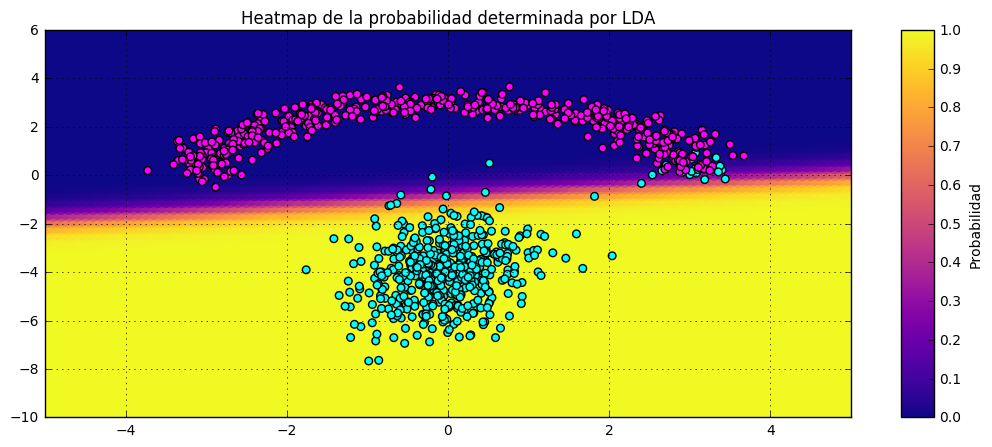

In [236]:
visualize_heatmap(lda_model, x_train, y_train, 'Heatmap de la probabilidad determinada por LDA')

Del heatmap de las probabilidades determinadas por LDA, se aprecia que el margen entre las dos clases pose un tamaño cercano a la unidad, además se observa que algunos elementos de la categoría 1 caen en el margen determinado por la LDA, implicando que la clasificación realizada por LDA no sea la adecuada para el conjunto de datos.

## c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión determinada por el algoritmo. Analice cualitativamente lo que observa y compare con LDA, las diferencias y semejanzas de estos. ¿Qué distribución de probabilidad asumen cada uno?

In [206]:
qda_model = QDA(store_covariances=True)
qda_model.fit(x_train,y_train);

Se entrena un clasificador QDA con el conjunto de datos creado, y para analizar el comportamiento del clasificador se visualiza la frontera generada por este

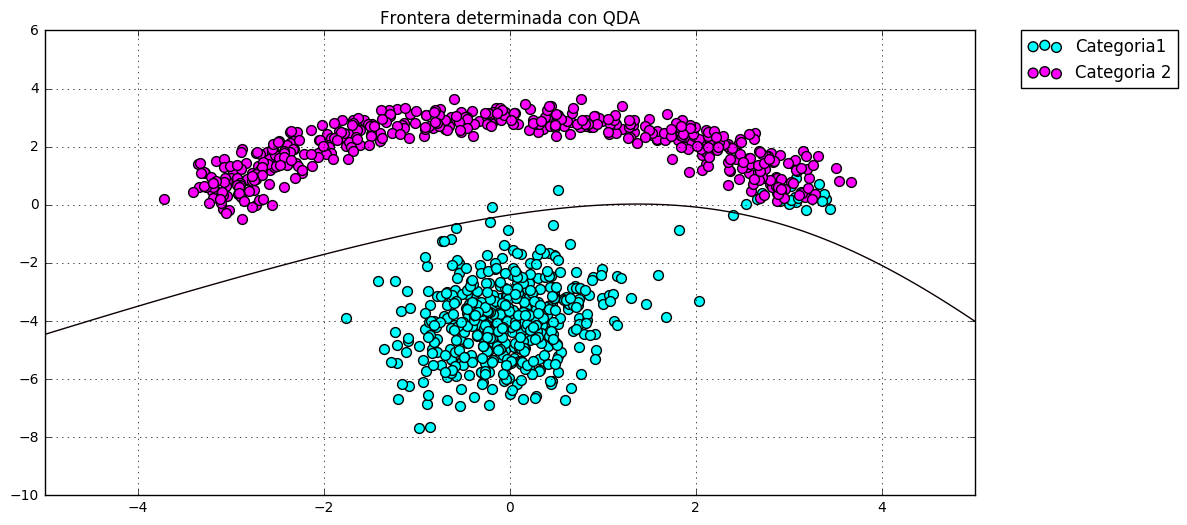

In [238]:
visualize_border(qda_model, x_train, y_train, 'Frontera determinada con QDA')

De la frontera determinada por QDA, a primera vista se aprecia el comportamiento cuadrático de esta, el cual se debe a que QDA no asume que las clases posean la misma covarianza, implicando que los términos cuadráticos del planteamiento original no se anulen, a diferencia de lo que ocurre en LDA.

De igual manera que en LDA la principal componente para dividir el conjunto de datos es la Y, pero a diferencia de LDA, QDA trata de ajustarse de mejor manera a la forma de los datos de la categoría 1, ya que donde se concentra la mayor cantidad de elementos de este conjunto, la frontera se desplaza en una pequeña cantidad ‘hacia arriba’, dándole una mejor cobertura a los elementos más alejados del centroide de la categoría 1, pero a pesar de esto QDA no fue capaz de separar las dos categorías en la zona de superposición. 

Para complementar el análisis de la frontera determinada con QDA, se procede a realizar un heartmap de la probabilidad de pertenecer a una clase u otra. 

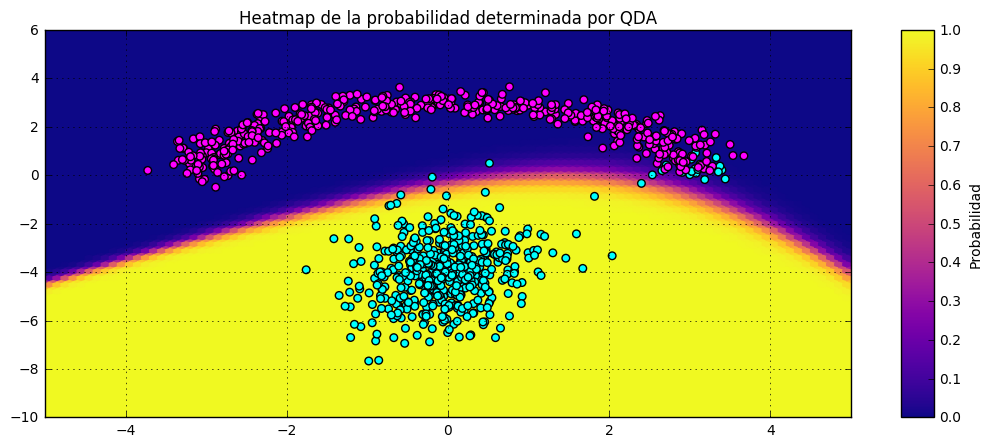

In [241]:
visualize_heatmap(qda_model, x_train, y_train, 'Heatmap de la probabilidad determinada por QDA')

Del heatmap de las probabilidades determinadas por QDA, es posible apreciar que el margen entre las dos clases no es mayor a la unidad, siendo lo mismo de lo ya observado para LDA. Se aprecia que una menor cantidad de puntos de la categoría 1 en la zona del margen entre las clases, lo cual puede indicar que QDA se adecuo de mejor manera a las cualidades del conjunto de datos en comparación a LDA.

---

De los resultados obtenidos por LDA y QDA se aprecia que estos métodos no fueron capases de separar las dos categorías en la zona de superposición. Se estima que este comportamiento se haya provocado por los supuestos que realizan estos algoritmos, los cuales son:
- Ambos modelos asumen que las categorías poseen una distribución Gaussiana. Lo cual provoca un menor rendimiento, en comparación a otros métodos, cuando las categorías presentan outliers, ya que estos elementos quedarían afuera se la zona esperara de valores.
- LDA asume que las dos categorías de datos posen la misma matriz de covarianza, resultando en una simplificación los cálculos necesarios para determinar la frontera de separación, y simplificando el modelo a un modelo lineal.

Dado estos supuestos, se podría pensar que LDA y QDA no son apropiados para el conjunto de datos en cuestión. Pero de las fronteras obtenidas, se aprecia que estas dividen la mayor parte de los puntos pentenecientes a cada categoria, haciendo que estos metodos sean una alternativa en comparacion a algunos plantamientos de mayor complejidad computacional. 

Finalmente, se grafican las elipses a las cuales los datos pertenecerían de cada categoría si estas tuviesen el comportamiento de una Gaussiana. 

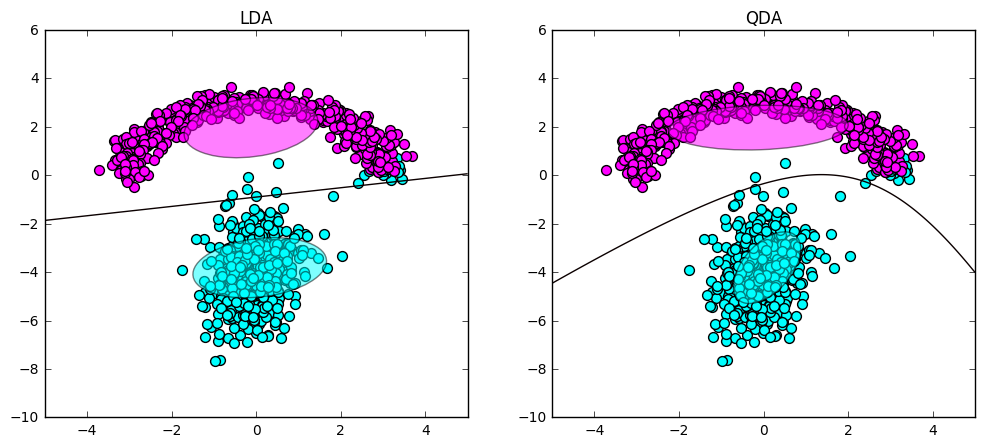

In [276]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,180 + angle, facecolor=color,linewidth=1, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)


f, axarr = plt.subplots(1, 2,figsize=(12,5))
classes = [0,1]
colors = [plt.cm.cool(float(i)) for i in classes]
axarr[0].scatter(x_train[y_train==0][:,0], x_train[y_train==0][:,1], s=50, c=colors[0], label=index_names[0])
axarr[0].scatter(x_train[y_train==1][:,0], x_train[y_train==1][:,1], s=50, c=colors[1], label=index_names[1])
plot_ellipse(axarr[0], lda_model.means_[0], lda_model.covariance_, colors[0])
plot_ellipse(axarr[0], lda_model.means_[1], lda_model.covariance_, colors[1])
x_min, x_max = axarr[0].get_xlim()
y_min, y_max = axarr[0].get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = lda_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:,0].reshape(xx.shape)
axarr[0].contour(xx, yy, Z, 1, cmap=plt.cm.hot)
axarr[0].axis((x_min, x_max, y_min, y_max))
axarr[0].set_title('LDA')

axarr[1].scatter(x_train[y_train==0][:,0], x_train[y_train==0][:,1], s=50, c=colors[0], label=index_names[0])
axarr[1].scatter(x_train[y_train==1][:,0], x_train[y_train==1][:,1], s=50, c=colors[1], label=index_names[1])
plot_ellipse(axarr[1], lda_model.means_[0], qda_model.covariances_[0], colors[0])
plot_ellipse(axarr[1], lda_model.means_[1], qda_model.covariances_[1], colors[1])
axarr[1].set_title('QDA')
Z = qda_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:,0].reshape(xx.shape)
axarr[1].contour(xx, yy, Z, 1, cmap=plt.cm.hot)
axarr[1].axis((x_min, x_max, y_min, y_max))

plt.show()

De la visualización aprecia con claridad que las categorías del conjunto de datos no poseen una distribución Gaussiana, pero como ya se mencionó el que las categorías no cumplan con los supuestos de LDA y QDA, no implica que no se puedan utilizar estos métodos en el conjunto de datos.

## d) Compare el error de clasificación de LDA y QDA para el conjunto de datos sintético.

Para finalizar la comparación entre los resultados obtenidos por LDA y QDA, se determina el error de clasificación de estos métodos sobre los datos utilizados en el entrenamiento.

In [235]:
y_pred_lda = lda_model.predict(x_train)
y_pred_qda = qda_model.predict(x_train)

index_names = ['LDA', 'QDA']
data = {
    'Accuracy':  pd.Series([
            accuracy_score(y_train, y_pred_lda),
            accuracy_score(y_train, y_pred_qda)
        ], index = index_names),
    'Miss Classification loss':  pd.Series([
            1-accuracy_score(y_train, y_pred_lda),
            1-accuracy_score(y_train, y_pred_qda)
        ], index = index_names),
    'Count Miss Classification':  pd.Series([
            (lda_model.predict(x_train)==y_train).tolist().count(False),
            (qda_model.predict(x_train)==y_train).tolist().count(False)
        ], index = index_names),
}

pd.DataFrame(data)[['Accuracy', 'Miss Classification loss', 'Count Miss Classification']]

,Accuracy,Miss Classification loss,Count Miss Classification
LDA,0.974,0.026,26
QDA,0.979,0.021,21


De los resultados obtenidos, se aprecia que la diferencia de QDA y LDA para la función de perdida de $0.004$, lo cual es un valor pequeño, indicando que QDA no aprende cualidades distintas a las aprendidas por LDA en la tarea de clasificación del conjunto de datos. El motivo de esto seguramente se deba, de acuerdo con lo ya mencionado, de que los conjuntos no poseen una distribución Gaussiana. 

## e) Entrene y ajuste el modelo de Regresíon Logística Regularizado utilizando como penalizador la norma $l_2$

En este punto se estudiará el modelo de clasificación RL con regularizador $l_2$ y los efectos de la contante del regularizador sobre la RL. Se procede a representar el conjunto de datos junto a la separación encontrada por el método para un determinado coeficiente y el heartmap utilizando la herramienta interactive de Jupyter

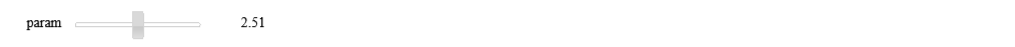

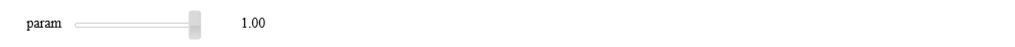

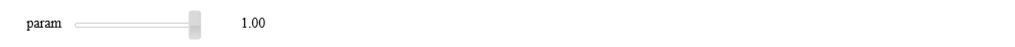

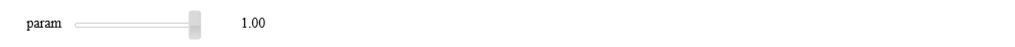

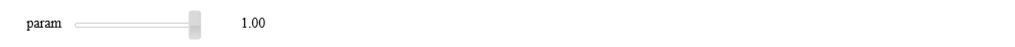

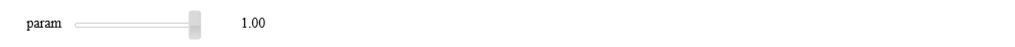

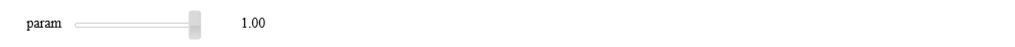

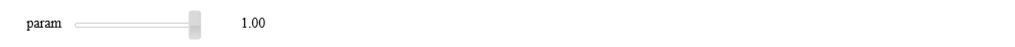

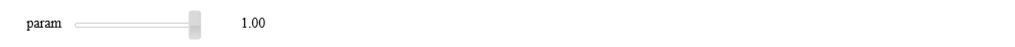

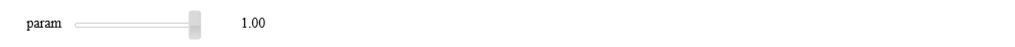

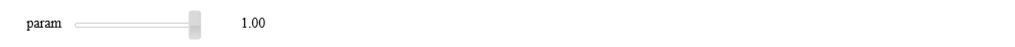

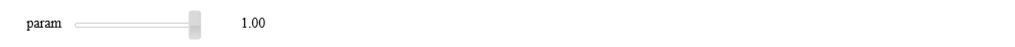

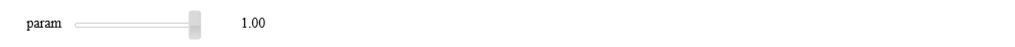

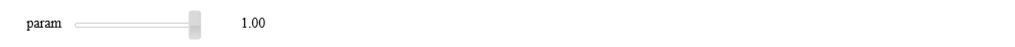

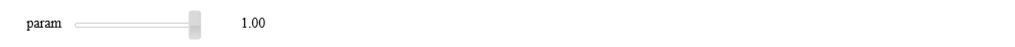

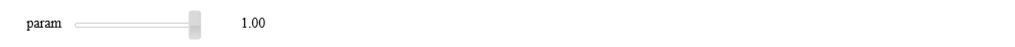

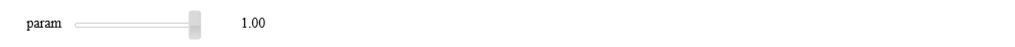

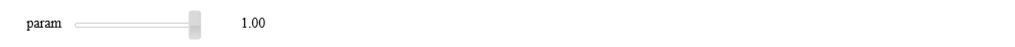

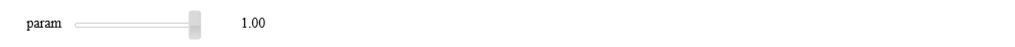

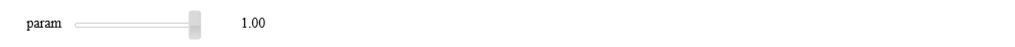

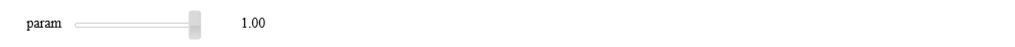

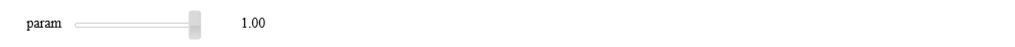

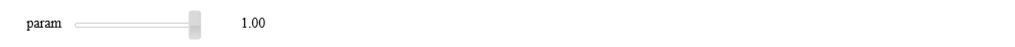

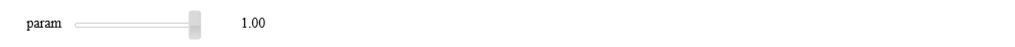

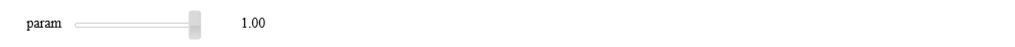

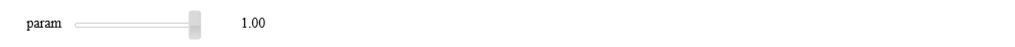

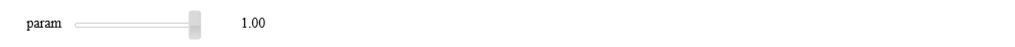

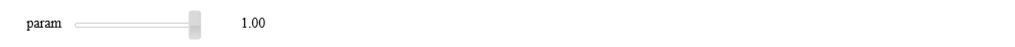

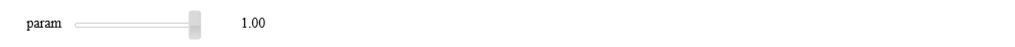

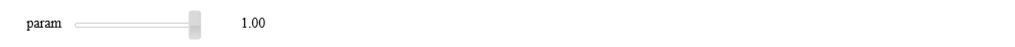

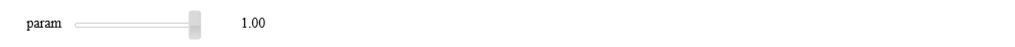

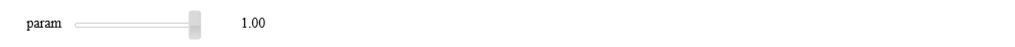

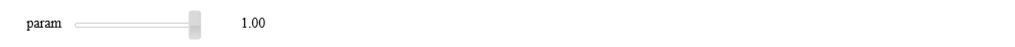

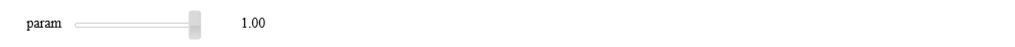

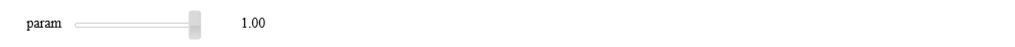

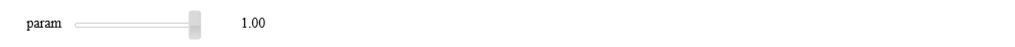

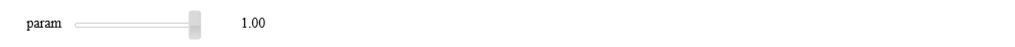

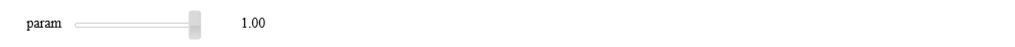

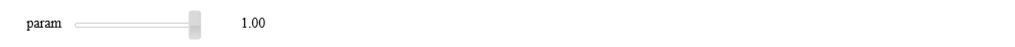

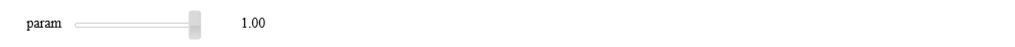

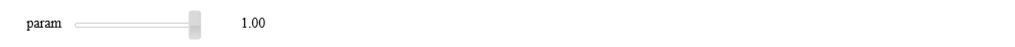

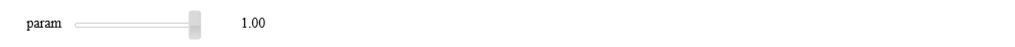

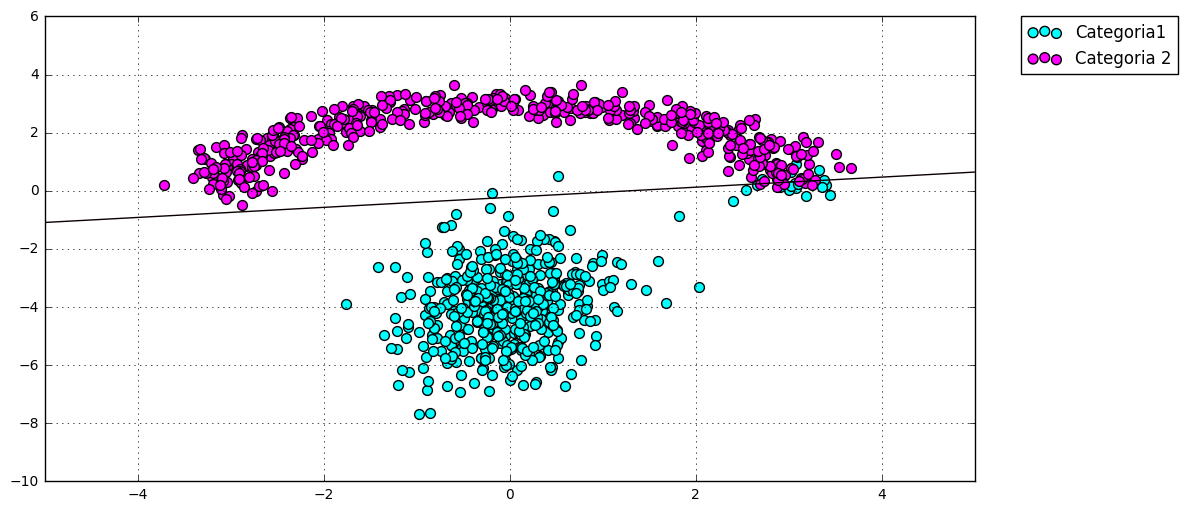

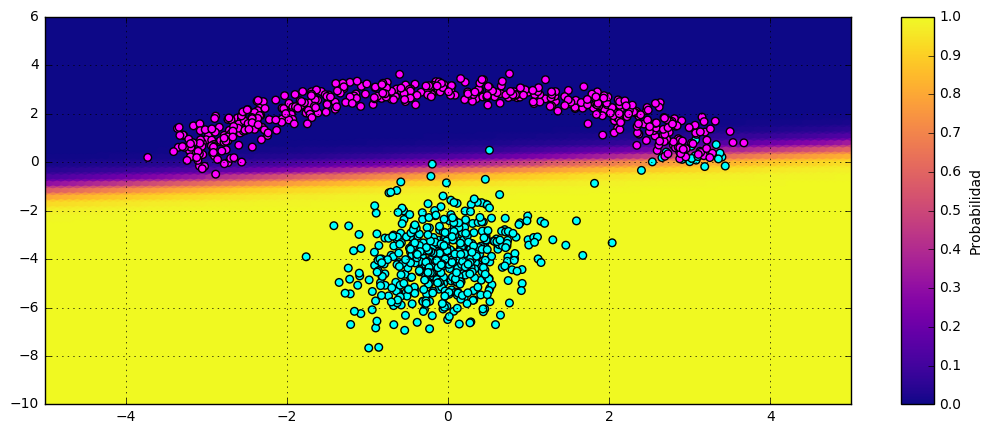

In [349]:
def train_model(param):
    model=LR()
    model.set_params(C=param,penalty='l2')
    model.fit(x_train, y_train)
    return model

p_min = 0.01
p_max = 5

interactive(visualize_border_interactive, param=(p_min,p_max))

Al ir incrementado el valor del parámetro de regularizador $l_2$, se aprecia un aumento en la pendiente de la frontera de separación entre las categorías, lo que implica que a medida que aumenta el coeficiente de regularización, la zona con los elementos superpuestos se tienden a clasificar con la categoría 1, en cambio sí se disminuye el coeficiente de regularización los puntos superpuestos tiene a clasificarse como elementos de la categoría 2.

Del heatmap se puede apreciar que, al disminuir el valor del factor de regularización, el margen entre las dos categorías aumenta, en cambio cuando aumenta el valor del regularizador, se observa una disminución de él margen entre las categorías. 

Para continuar el estudio de la RL regularizada, se grafica el valor de la función de perdida, entre 0.0001 y 5, resultando el siguiente gráfico: 

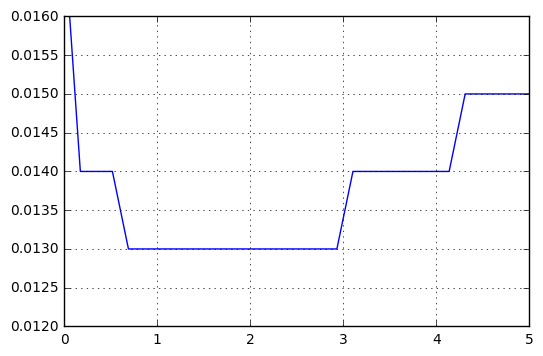

In [330]:
alphas_ = np.linspace(0.0001, 5, 30)
model = lr_model=LR()
coefs = []
for a in alphas_:
    model.set_params(C=a,penalty='l2')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    coefs.append(1-accuracy_score(y_train, y_pred))
plt.plot(alphas_, coefs)
plt.grid(True)
plt.axis((0, 5, 0.012, 0.016))
plt.show()

Del grafico anterior se aprecia que entre un valor menor a uno y un valor menor a tres se obtienen los mínimos para el valor de la función de perdida para el conjunto de entrenamiento. Con esta información se define que el mejor valor para el regularizador para una LR regularizada con $l_2$ y entrenada con el conjunto de datos en estudio, es igual a $2.5$, ya que en este valor permite minimizar el error de entrenamiento y además de ofrecer un margen del tamaño conveniente para clasificar las dos clases.

Finalmente se grafican los cambios de los coeficientes de la RL en función del coeficiente de regularización:

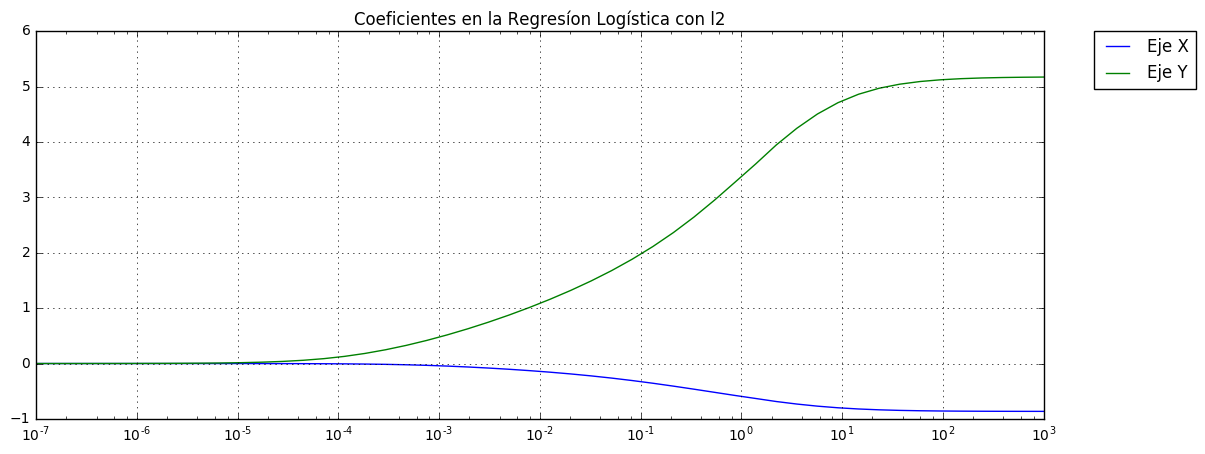

In [303]:
names_regressors = ['Eje X', 'Eje Y']
alphas_ = np.logspace(3,-7,base=10)
coefs = []
model = lr_model=LR()
for a in alphas_:
    model.set_params(C=a,penalty='l2')
    model.fit(x_train, y_train)
    coefs.append(model.coef_)
plt.figure(figsize = (13, 5))
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Coeficientes en la Regresíon Logística con l2')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

De la figura anterior es posible apreciar que la componente más importante para realizar la decisión de clasificación es la Y, siendo este el mismo comportamiento observado en LDA y QDA. De los cambios de magnitud en los coeficientes de la regresión se aprecia que la mayor variación ocurre entre 0,1 y 10, además que para valores mayores a 10 del coeficiente de regularización no se aprecian cambios notorios en los coeficientes de la RL, y que para valores menores a 0.0001 los coeficientes de la regresión son prácticamente nulos, pero a de señalarse que el regularizador $l_2$ no asegura que los coeficientes de la regresión sean iguales a 0.

## f) Entrene y ajuste una Máquina de Vectores de Soporte (SMV) Lineal. 

En este punto se estudiarán las SVM lineales, y los efectos al ir variando los parámetros de esta, para lo cual se utiliza el módulo interactive, al igual que en el punto anterior:

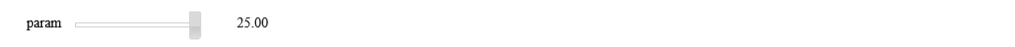

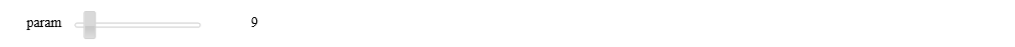

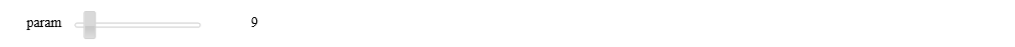

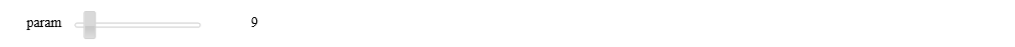

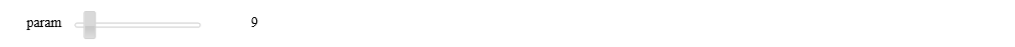

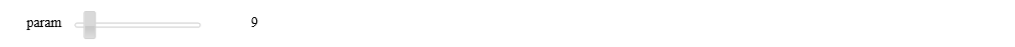

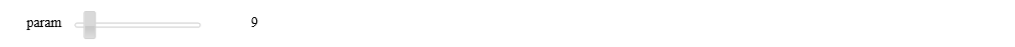

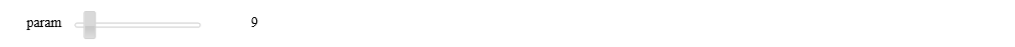

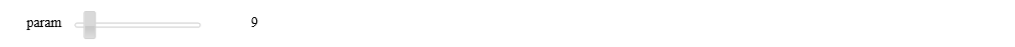

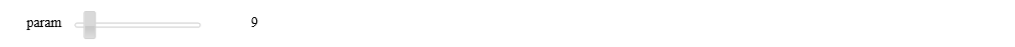

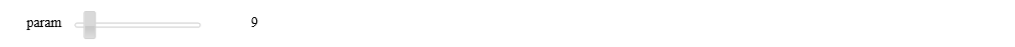

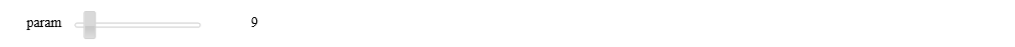

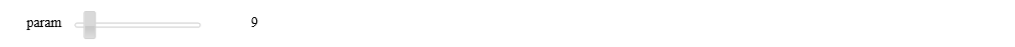

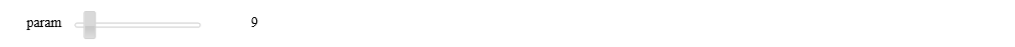

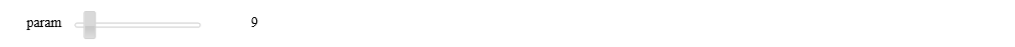

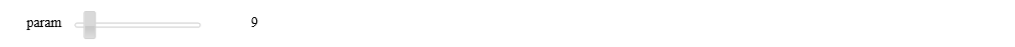

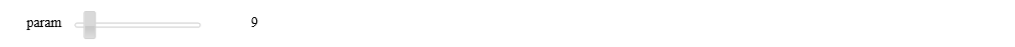

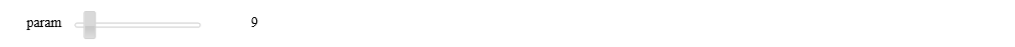

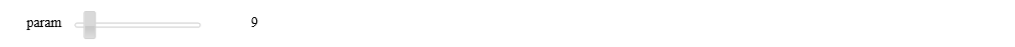

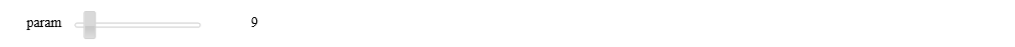

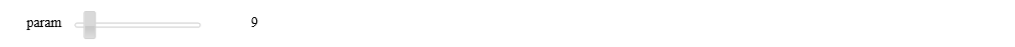

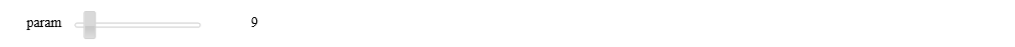

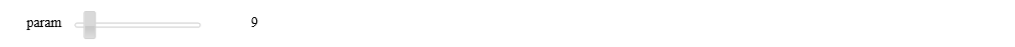

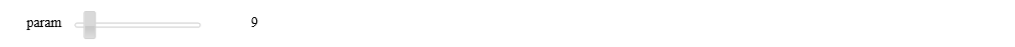

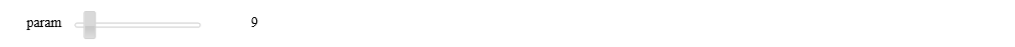

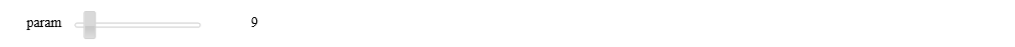

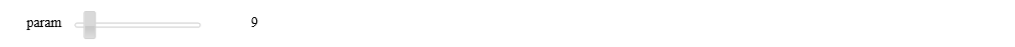

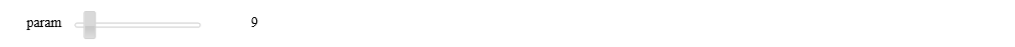

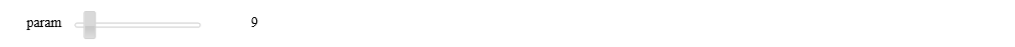

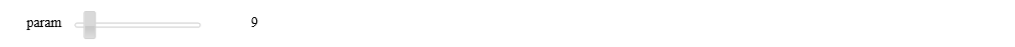

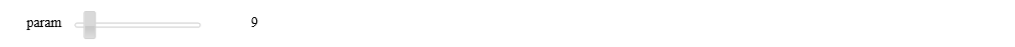

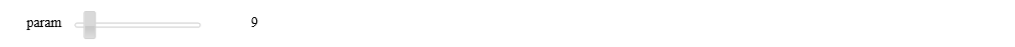

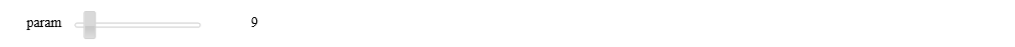

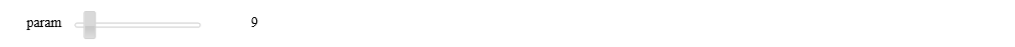

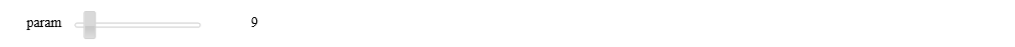

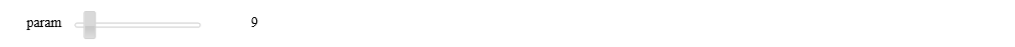

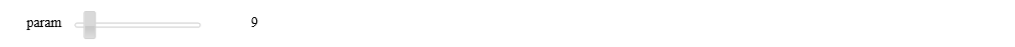

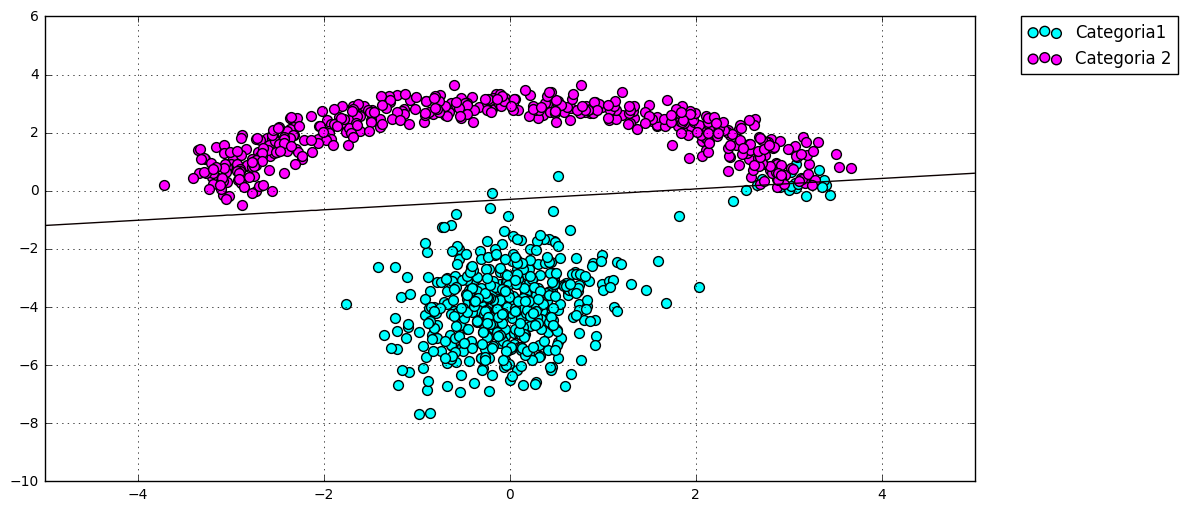

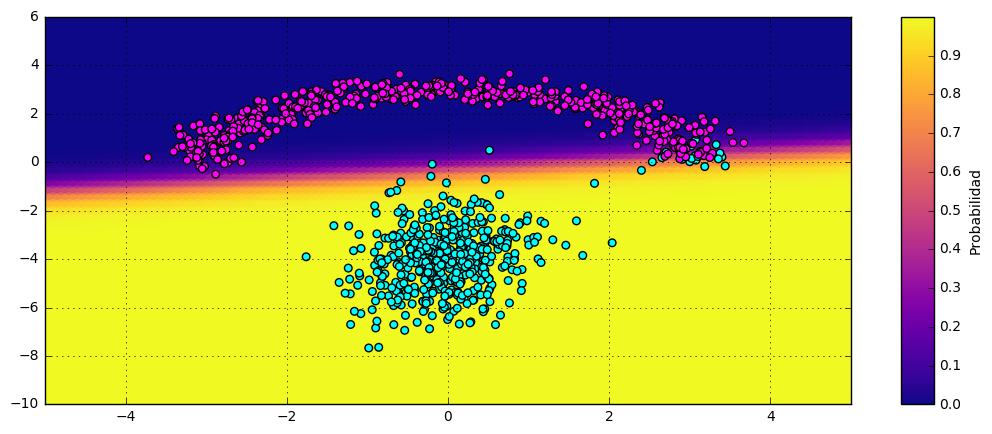

In [357]:
def train_model(param):
    model = SVM(probability=True)
    model.set_params(C=param,kernel='linear')
    model.fit(x_train, y_train)
    return model

p_min = 0.01
p_max = 25

interactive(visualize_border_interactive, param=(p_min,p_max))

Al variar el parámetro de la SVM lineal se observa que a medida que este aumenta también aumenta la pendiente de la frontera de división, lo cual corresponde al mismo comportamiento que en la LR regularizada. También se señala que al cambiar el parámetro de la SVM lineal, el margen de la frontera no se ve afectado, lo anterior correspondería a una ventaja de las SVM lineales en comparación a las LR regularizada, ya que en la SVM el parámetro solo influye en la pendiente de la frontera, en cambio en la LR regularizada el parámetro influye en la pendiente de la frontera y en el margen de la frontera. 

Se continua, graficando la función de perdida de la SMV con distintos parámetros, para el intervalo 0 a 25:

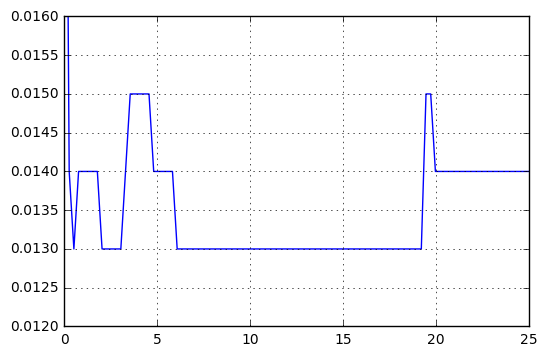

In [356]:
alphas_ = np.linspace(0.01, 25, 100)
model = SVM(probability=True)
coefs = []
for a in alphas_:
    model.set_params(C=a,kernel='linear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    coefs.append(1-accuracy_score(y_train, y_pred))
plt.plot(alphas_, coefs)
plt.grid(True)
plt.axis((0, 25, 0.012, 0.016))
plt.show()

Del gráfico anterior se aprecia que el valor mínimo de la función de perdida es igual a 0.0130 y este se registra en más de un parámetro, y como en la SVM lineal el parámetro solo afecta la inclinación de la recta, se puede elegir cualquiera de los que minimizan la función de perdida. 

## g) Entrene y ajuste una Máquina de Vectores de Soporte (SMV) no Lineal.

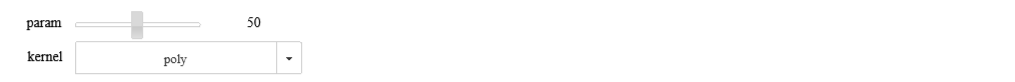

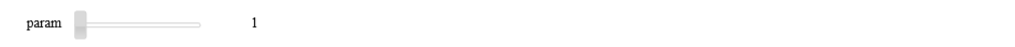

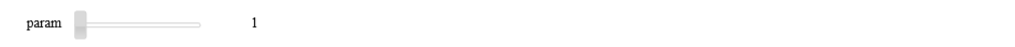

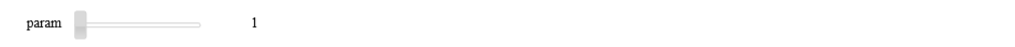

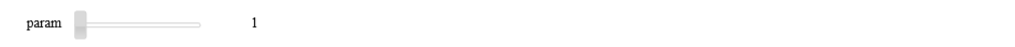

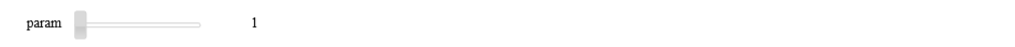

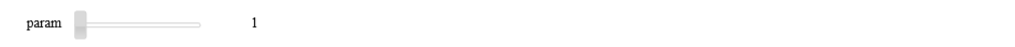

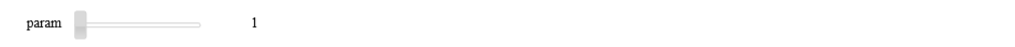

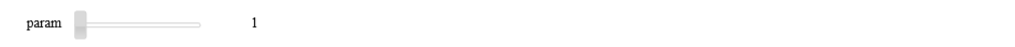

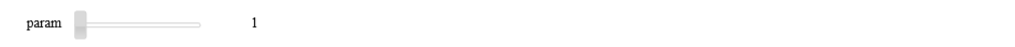

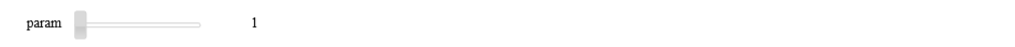

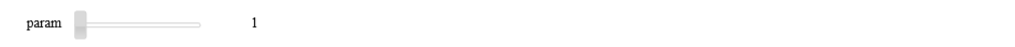

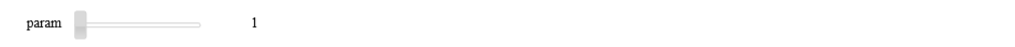

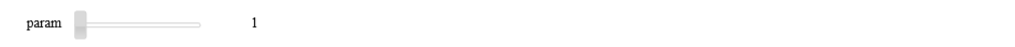

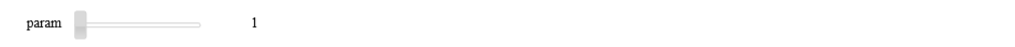

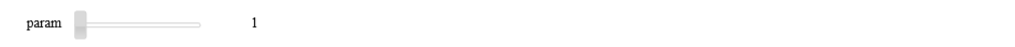

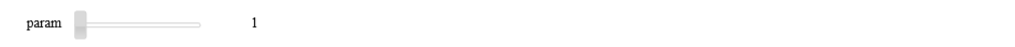

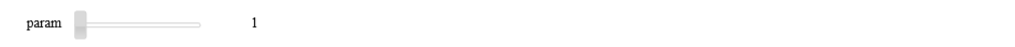

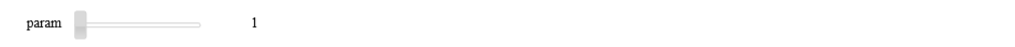

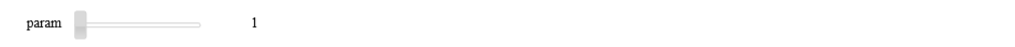

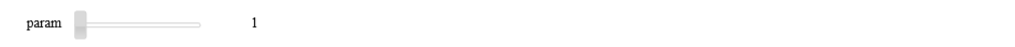

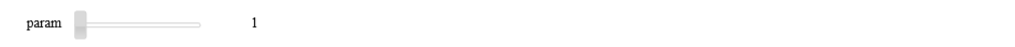

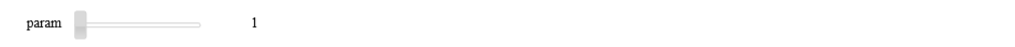

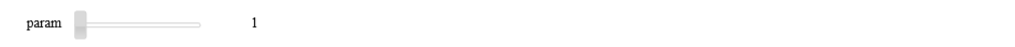

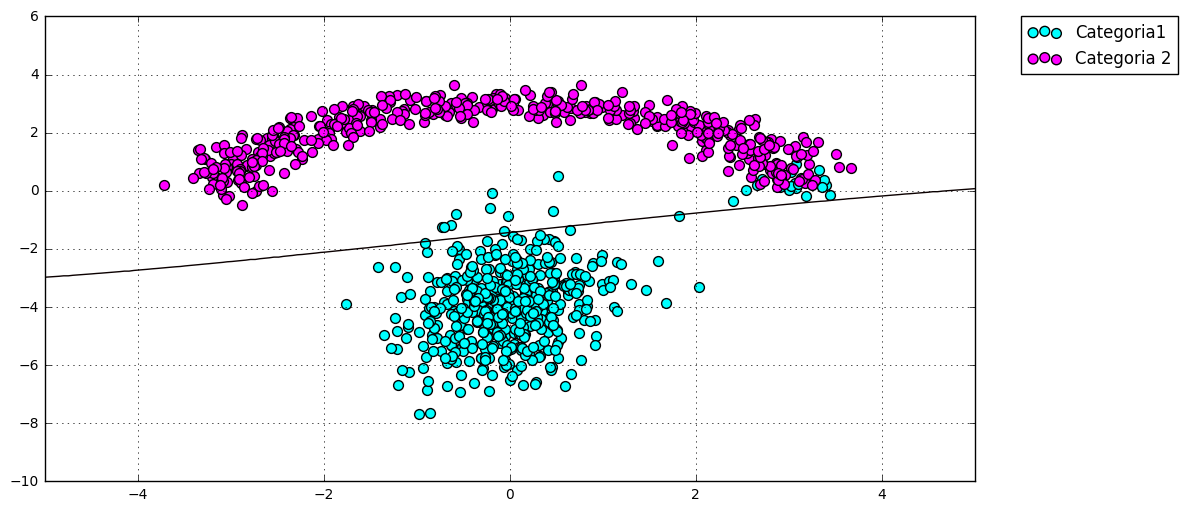

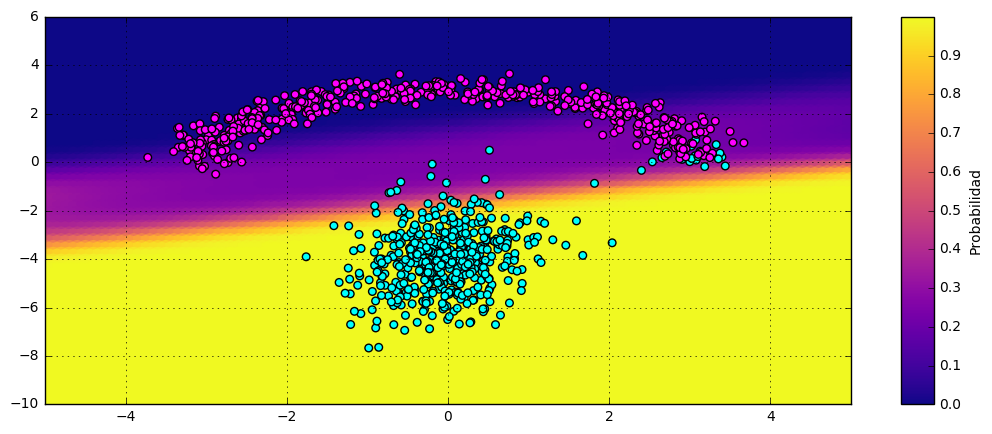

In [374]:
def visualize_border_interactive(param, kernel):
    model = train_model(param, kernel)
    visualize_border(model, x_train, y_train)
    visualize_heatmap(model, x_train, y_train)

def train_model(param, kernel):
    model = SVM(probability=True)
    model.set_params(C=param,kernel=kernel) #, ‘poly’, ‘rbf’, ‘sigmoid’(error?)
    model.fit(x_train, y_train)
    return model

p_min = 1
p_max = 100

interactive(visualize_border_interactive, param=(p_min,p_max), kernel=['rbf', 'poly'])

Para estudiar la SVM no lineales, se comparan los resultados de utilizar un kernel Polynomial y un kernel RBF. El kernel RBF encierra a la categoría 2, y asigna la mayor parte del plano como la categoría1, de la frontera generada se aprecia que no es lineal, además en el lado izquierdo de la figura se aprecia un gran margen, en cambio en el sector donde las dos categorías se juntan el margen disminuye drásticamente, lo cual podría indicar la presencia de overfiting. Del kernel Polynomial se comporta similar que la LR o la SVM lineal en cuanto a la forma de la frontera, pero al analizar la probabilidad de pertenecer a una categoría o no, se aprecia una franja de probabilidad cercana al 0.3, que recorre todo el eje X y la amplitud de la franja se relaciona con la presencia de outliers de la categoría 1.

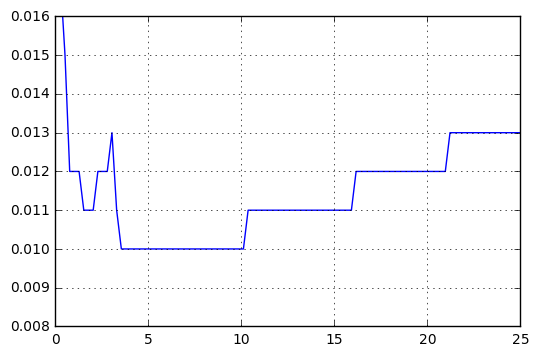

In [361]:
alphas_ = np.linspace(0.01, 25, 100)
model = SVM(probability=True)
coefs = []
for a in alphas_:
    model.set_params(C=a,kernel='rbf')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    coefs.append(1-accuracy_score(y_train, y_pred))
plt.plot(alphas_, coefs)
plt.grid(True)
plt.axis((0, 25, 0.008, 0.016))
plt.show()

Para analizar la función de perdida en la SVM no lineal, solo se utilizó la SVM con kernel RBF, ya que el kernel Polynomial no presenta una gran diferencia en comparación a los métodos ya estudiados. Del grafico del valor de la función de perdida en función del parámetro de la SVM con kernel RBF, es posible apreciar que el mínimo valor corresponde a $0.010$, el cual es el menor encontrado hasta el momento, lo cual hace pensar que no está libre de overfiting, este mínimo se logra cuando el parámetro de la SVM se encuentra entre 5 y 10.

## h) Contruya un Árbol de Decisión de múltiples niveles para clasificar el conjunto de datos.

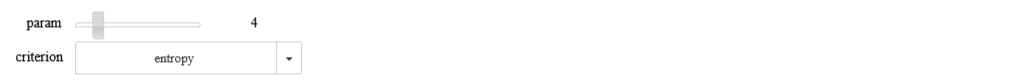

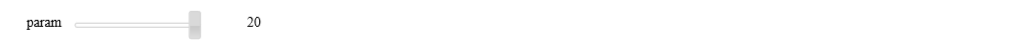

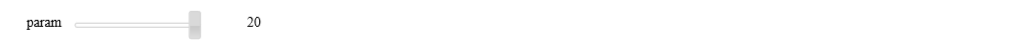

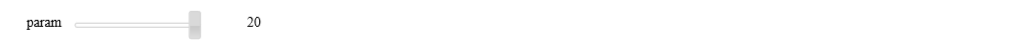

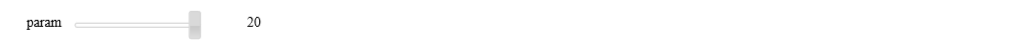

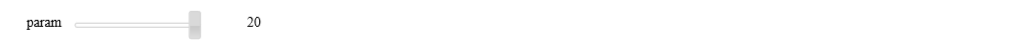

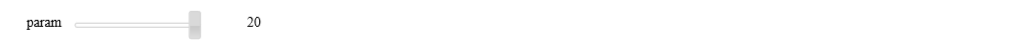

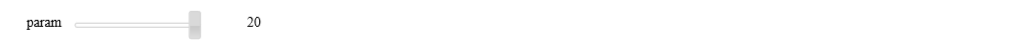

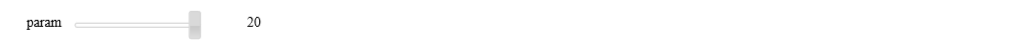

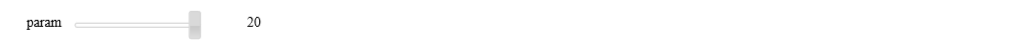

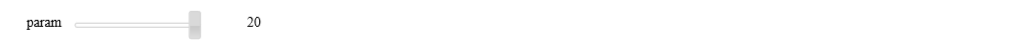

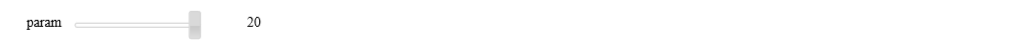

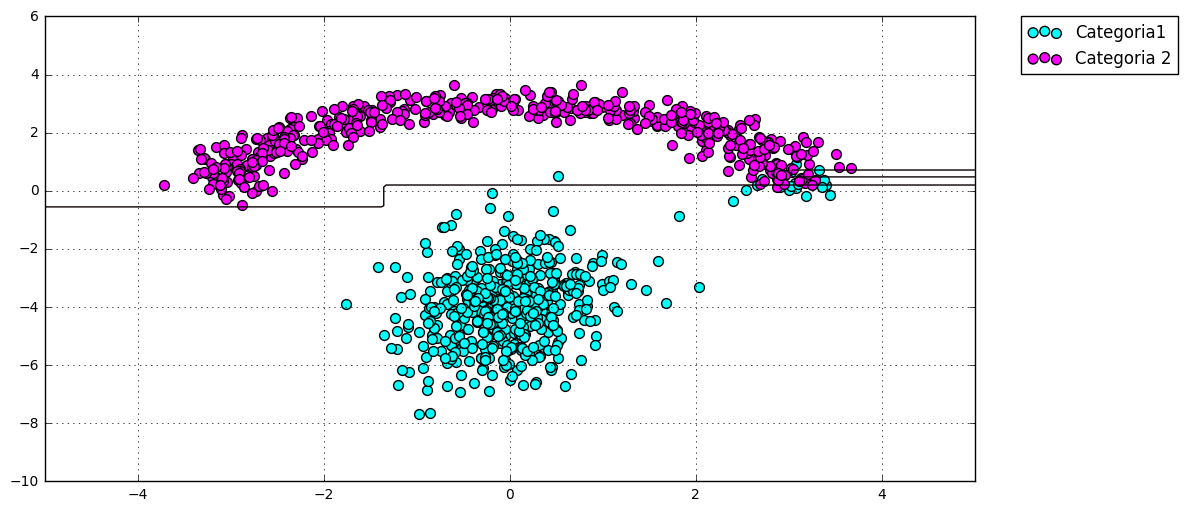

In [381]:
def visualize_border_interactive(param, criterion):
    model = train_model(param, criterion)
    visualize_border(model, x_train, y_train)
def train_model(param, criterion):
    model = Tree()
    model.set_params(max_depth=param,criterion='gini',splitter='best') #'gini','entropy','variance'
    model.fit(x_train, y_train)
    return model

p_min = 1
p_max = 20

interactive(visualize_border_interactive,param=(p_min,p_max),criterion=['gini','entropy'])

Para analizar el comportamiento de los árboles de decisión, se estudiaron los criterios Gini y Entropy, al aumentar el valor del parámetro de los árboles, se observa una mejora en el rendimiento para ambos criterios, pero el problema de un elevado parámetro es un alto nivel de ovetfiting.

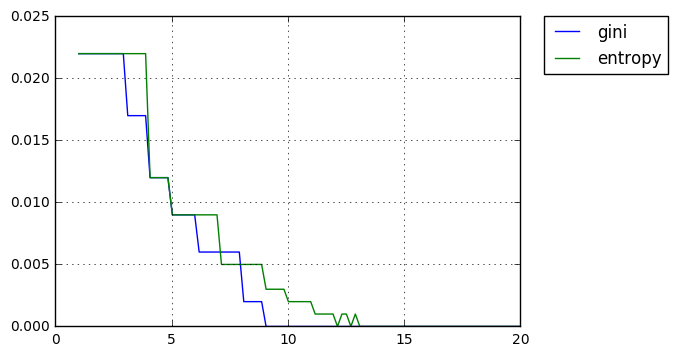

In [395]:
alphas_ = np.linspace(1, 20, 100)
model = Tree()
gini = []
entropy = []
for param in alphas_:
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    gini.append(1-accuracy_score(y_train, y_pred))
    model.set_params(max_depth=param,criterion='entropy',splitter='best')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    entropy.append(1-accuracy_score(y_train, y_pred))
plt.plot(alphas_, gini, label='gini')
plt.plot(alphas_, entropy, label='entropy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Al analizar el gráfico de la función de perdida en función de la máxima altura permitida, se aprecia que en general Gini obtiene mejores resultados que Entropy en el conjunto de entrenamiento, además se observa que un valor elevado de la máxima altura es riesgoso ya que al aumentar la altura máxima se aumenta el overfiting realizado por el modelo, implicando que este no sea capaz de predecir correctamente la probabilidad de las categorías estudiadas. 

## i) Construta un algorimo *k-NN* para la clasificar el conjunto de datos.

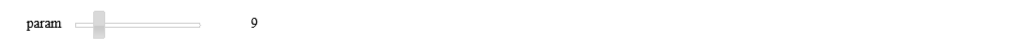

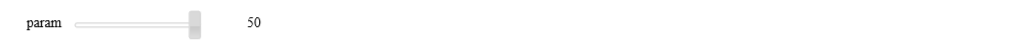

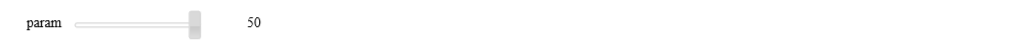

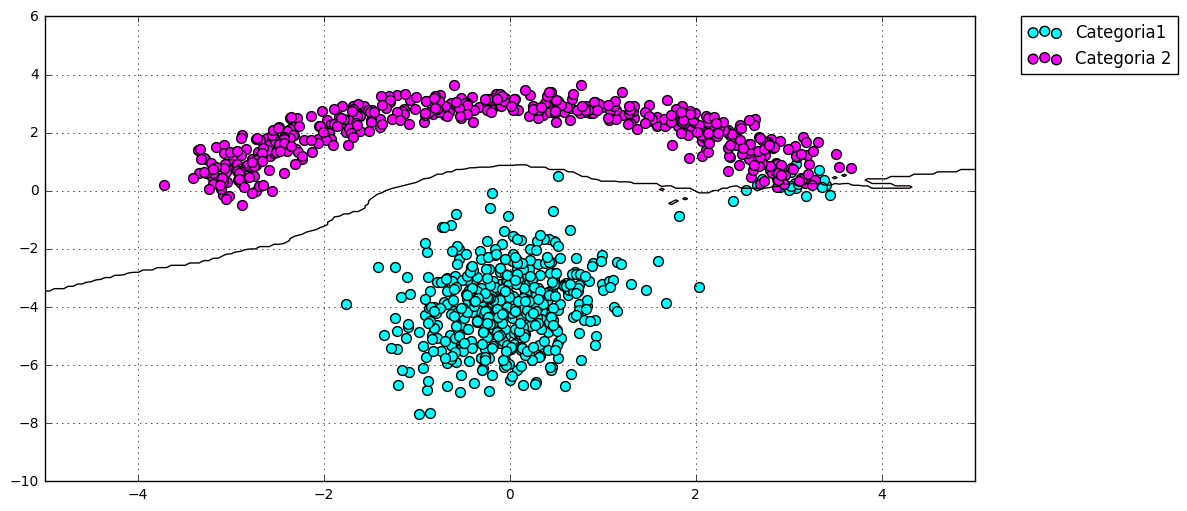

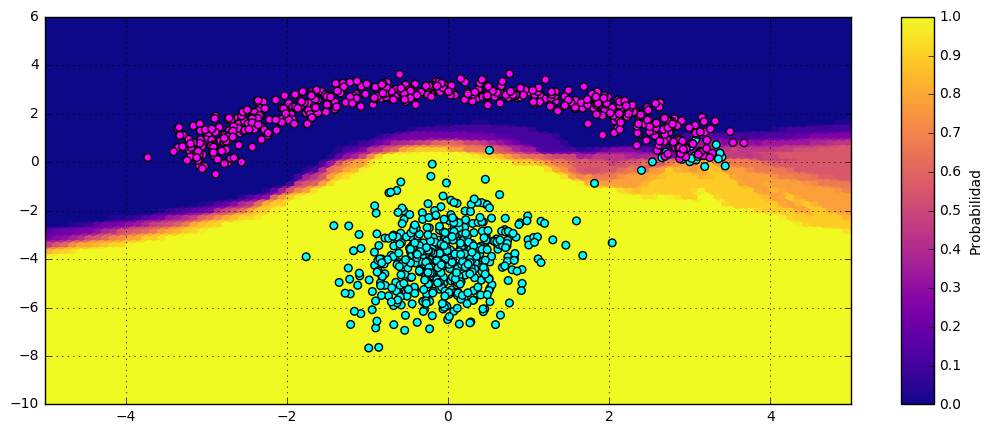

In [384]:
def train_model(param):
    model=KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(x_train, y_train)
    return model

p_min=1
p_max=50
interactive(visualize_border_interactive,param=(p_min,p_max))

Del algoritmo *k-NN* es posible apreciar que a medida que aumenta la cantidad de vecinos el modelo obtenido aumenta su capacidad de generalizar y así disminuyendo la cantidad de overfiting presente en este, pero producto de esto es esperable que aumente el error de clasificación del modelo. Al observar el mapa de calor de la probabilidad de pertenecer a una clase u otra, se observa que el modelo en la zona de la superposición de categorías asigna probabilidades cercanas a 0.5, esto puede indicar que el modelo no aprende las cualidades necesarias para separar correctamente los conjuntos, pero si hace el intento de sepáralas y no como otros modelos, como por ejemplo QDA.

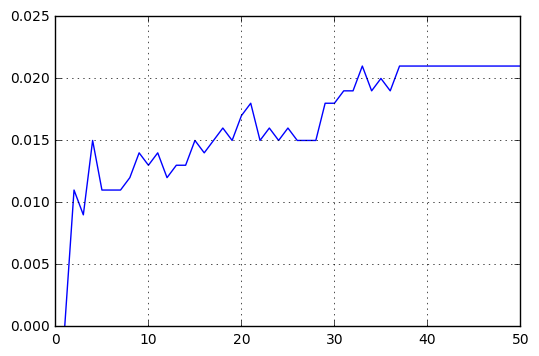

In [396]:
alphas_ = range(1,51)
model = KNeighborsClassifier()
coefs = []
for a in alphas_:
    model.set_params(n_neighbors=a)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    coefs.append(1-accuracy_score(y_train, y_pred))
plt.plot(alphas_, coefs)
plt.grid(True)
plt.show()

De la visualización de la función de perdida se aprecia que en valores bajos de la cantidad de vecinos se logran los mínimos, pero seguramente esto también este acompañado de overfiting, y al ir aumentando la cantidad de vecinos, la función de perdida crese lentamente hasta estancarse, en un valor fijo, en los 35 vecinos aproximadamente. Seguramente el mejor valor para el conjunto de datos estudiados se encuentre entre los 10 a 20 vecinos. 